In [663]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


Lets first read the contents of the CSV File, to make sure everything is there

In [664]:
blockData = pd.read_csv("trust_chain_dataset_predictive.csv")
blockData

,Transaction ID,Timestamp,Item ID,Supplier ID,Customer ID,Location,Temperature,Humidity,GPS Coordinates,Order Amount,Quantity Shipped,Order Status,Payment Status,Time to Delivery,Quantity Mismatch,Fraud Indicator,Transaction Hash,Smart Contract Status,Compliance Check
0,TX00001,2025-02-05 13:58:29.739685,9102,S4,C9,Chicago,12.248374,67.459523,"(36.4275, -116.2052)",2996,153,Pending,Overdue,6,12,1,0xc11a,Active,0
1,TX00002,2025-02-04 13:58:29.739685,9435,S8,C6,Chicago,18.968854,41.879883,"(38.3798, -106.2317)",1182,76,Delivered,Paid,4,9,0,0x7b36,Completed,0
2,TX00003,2025-02-03 13:58:29.739685,9860,S6,C2,Chicago,15.050121,41.514624,"(41.5735, -93.3818)",1939,63,Pending,Overdue,5,2,1,0x15ce,Triggered,0
3,TX00004,2025-02-02 13:58:29.739685,9270,S3,C2,NY,17.310409,41.266084,"(36.2805, -96.2122)",2439,74,Shipped,Paid,6,1,0,0x8be6,Triggered,1
4,TX00005,2025-02-01 13:58:29.739685,9106,S4,C3,Chicago,6.741711,67.905965,"(38.316, -87.2957)",2915,101,Shipped,Paid,1,10,0,0x8a2d,Active,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,TX10344,1996-10-12 13:58:29.784898,9776,S5,C7,Chicago,5.247287,63.216954,"(37.7704, -92.7947)",2005,63,Delivered,Overdue,7,8,0,0x40dc,Active,1
10344,TX10345,1996-10-11 13:58:29.784898,9144,S6,C5,SF,6.117547,56.396645,"(37.8048, -106.6378)",1282,161,Delivered,Paid,2,4,0,0xf37a,Active,1
10345,TX10346,1996-10-10 13:58:29.784898,9068,S7,C4,LA,7.637715,42.554104,"(40.8892, -83.8448)",1592,183,Shipped,Paid,1,13,0,0xc4ac,Completed,0
10346,TX10347,1996-10-09 13:58:29.784898,9057,S2,C5,NY,6.707571,69.055645,"(37.1189, -114.84)",2677,168,Pending,Overdue,3,4,0,0xd665,Triggered,1


Here we proprocess and filter our data by only what we may need for Guassian Naive Bayes Algorithm. Not all features may be relevant or even helpful in our classification task particularly non numerical data. In this case we are choosing to encode non-numerical data so that we may use it in our Naive Bayes Classification.

In [665]:
columns_to_keep = ['Order Status', 'Payment Status', 'Quantity Mismatch', 'Time to Delivery', 'Order Amount', 'Quantity Shipped', 'Smart Contract Status', 'Compliance Check', 'Item ID', 'Supplier ID', 'Location', 'Fraud Indicator']
blockData_clean = blockData[columns_to_keep].copy()

blockData_clean

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,Pending,Overdue,12,6,2996,153,Active,0,9102,S4,Chicago,1
1,Delivered,Paid,9,4,1182,76,Completed,0,9435,S8,Chicago,0
2,Pending,Overdue,2,5,1939,63,Triggered,0,9860,S6,Chicago,1
3,Shipped,Paid,1,6,2439,74,Triggered,1,9270,S3,NY,0
4,Shipped,Paid,10,1,2915,101,Active,1,9106,S4,Chicago,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,Delivered,Overdue,8,7,2005,63,Active,1,9776,S5,Chicago,0
10344,Delivered,Paid,4,2,1282,161,Active,1,9144,S6,SF,0
10345,Shipped,Paid,13,1,1592,183,Completed,0,9068,S7,LA,0
10346,Pending,Overdue,4,3,2677,168,Triggered,1,9057,S2,NY,0


Encoding our non-numerical ordinal data, referencing: https://www.geeksforgeeks.org/machine-learning/ml-label-encoding-of-datasets-in-python/

In [666]:
numerate = LabelEncoder()
categorical_columns = ['Order Status', 'Payment Status', 'Smart Contract Status', 'Supplier ID', 'Location']

for col in categorical_columns:
    blockData_clean[col] = numerate.fit_transform(blockData_clean[col])

blockData_clean

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,1,0,12,6,2996,153,0,0,9102,4,0,1
1,0,1,9,4,1182,76,1,0,9435,8,0,0
2,1,0,2,5,1939,63,2,0,9860,6,0,1
3,2,1,1,6,2439,74,2,1,9270,3,2,0
4,2,1,10,1,2915,101,0,1,9106,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0,0,8,7,2005,63,0,1,9776,5,0,0
10344,0,1,4,2,1282,161,0,1,9144,6,3,0
10345,2,1,13,1,1592,183,1,0,9068,7,1,0
10346,1,0,4,3,2677,168,2,1,9057,2,2,0


In [667]:
blockData_randomized = blockData_clean.sample(frac=1, random_state=42)
blockData_randomized = blockData_randomized.reset_index(drop=True)
blockData_randomized

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,2,1,11,2,2352,183,0,0,9080,6,2,0
1,2,1,4,3,2426,122,0,1,9295,4,1,0
2,1,0,5,9,1718,182,0,0,9595,5,0,1
3,0,0,3,2,1318,130,0,0,9375,3,3,0
4,2,0,6,8,1618,78,0,0,9573,9,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0,0,5,5,2240,83,0,0,9435,4,3,0
10344,2,1,10,2,1920,125,0,1,9775,4,1,0
10345,2,1,13,1,2199,139,1,0,9014,3,3,0
10346,2,0,10,4,2664,151,0,1,9341,1,2,0


Here we seperate the outcomes from the classes

In [668]:
X = blockData_randomized.drop('Fraud Indicator', axis=1)
y = blockData_randomized['Fraud Indicator']

X.head()

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location
0,2,1,11,2,2352,183,0,0,9080,6,2
1,2,1,4,3,2426,122,0,1,9295,4,1
2,1,0,5,9,1718,182,0,0,9595,5,0
3,0,0,3,2,1318,130,0,0,9375,3,3
4,2,0,6,8,1618,78,0,0,9573,9,2


Taking a look at our initial fraud labels

In [669]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Fraud Indicator, dtype: int64

We are spliting our data into training data and a test set here with an 80/20 split respectively

In [670]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, shuffle=True)
X_train.shape

(8278, 11)

## Naive Bayes Classification

Using a Gaussian Naive Bayes classification algorithm, which uses a normal distribution and calculates probabilities based on Bayes theorem. This algorithm works well where datasets features are independent of each other.

In [671]:
model = GaussianNB()
model.fit(X_train,y_train)
modelPrediction=model.predict(X_test)

modelPrediction

array([1, 0, 0, ..., 0, 0, 1], shape=(2070,))

Verifying our predictions against our test data

In [672]:
np.sum(y_test==modelPrediction) ## number of correct predictions

np.int64(1678)

# Accuracy Rate 

In [673]:
accuracy = np.sum(y_test==modelPrediction) / modelPrediction.size
accuracy

np.float64(0.8106280193236715)

Recall score for NB referencing: https://www.geeksforgeeks.org/machine-learning/compute-classification-report-and-confusion-matrix-in-python/

In [674]:
print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      1527
           1       0.58      0.97      0.73       543

    accuracy                           0.81      2070
   macro avg       0.78      0.86      0.79      2070
weighted avg       0.88      0.81      0.82      2070



# Random Forest 

Using a Random Forest classification model with 100 decision trees to improve prediction accuracy. Random Forest combines multiple decision trees to reduce overfitting and provide more robust predictions compared to a single decision tree algorithm. Referencing https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

In [675]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)

rf_prediction

array([0, 0, 0, ..., 0, 0, 0], shape=(2070,))

Number of correct Random Forest predictions

In [676]:
np.sum(y_test == rf_prediction)

np.int64(1907)

Visualizing one decision tree, referencing: https://www.geeksforgeeks.org/machine-learning/changing-colors-for-decision-tree-plot-using-sklearn-plot-tree/

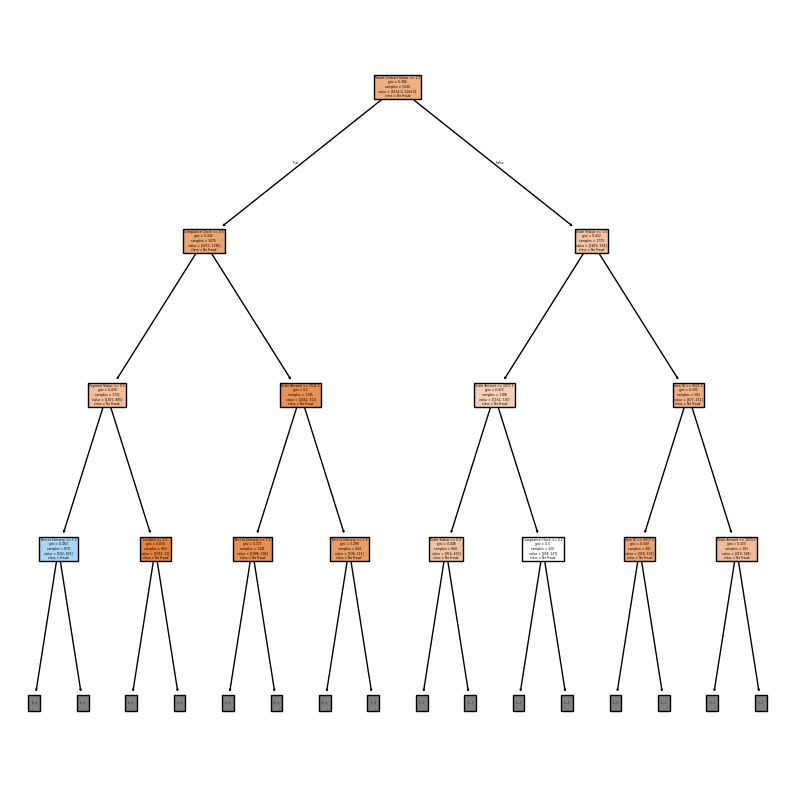

In [677]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, class_names=['No Fraud', 'Fraud'], filled=True, max_depth=3)
plt.show()

Accuracy Rate

In [678]:
rf_accuracy = np.sum(y_test == rf_prediction) / rf_prediction.size
rf_accuracy

np.float64(0.921256038647343)

Recall Score for RF 

In [679]:
print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1527
           1       0.85      0.85      0.85       543

    accuracy                           0.92      2070
   macro avg       0.90      0.90      0.90      2070
weighted avg       0.92      0.92      0.92      2070



# Naive Bayes Vs. Random Forest

Comparing our findings we can see that Random Forest significantly outperforms Naive Bayes with accuracy rate of ~92% vs ~81.5% respectively. The Random Forest's approach of combining multiple decision trees provides better generalization and handles complex feature more effectively than the Naive Bayes algorithm.

In [680]:
# Compare both models
print("Naive Bayes Accuracy:", accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Naive Bayes Accuracy: 0.8106280193236715
Random Forest Accuracy: 0.921256038647343


# XGBoost 

In [681]:
XGBmodel = xgb.XGBClassifier(n_estimators=8)
XGBmodel.fit(X_train,y_train)
XGmodelPrediction=XGBmodel.predict(X_test)

XGmodelPrediction

array([0, 0, 0, ..., 0, 0, 0], shape=(2070,))

Evaluating the accuracy of the XGB Model

In [682]:
XGBaccuracy = accuracy_score(y_test, XGmodelPrediction)
print(f"Accuracy: {XGBaccuracy * 100:.2f}%")


Accuracy: 93.00%


Feature Importance + Recall Score

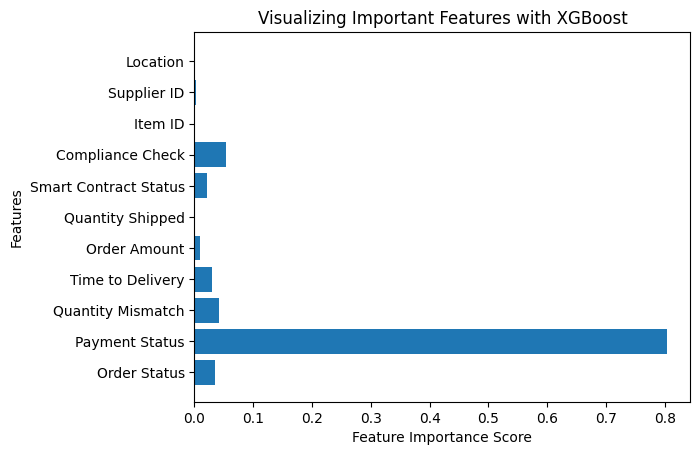


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1527
           1       0.89      0.84      0.86       543

    accuracy                           0.93      2070
   macro avg       0.92      0.90      0.91      2070
weighted avg       0.93      0.93      0.93      2070



In [683]:
feature_importance = XGBmodel.feature_importances_

# Plotting feature importance
plt.barh(X.columns, feature_importance)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features with XGBoost')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, XGBmodel.predict(X_test)))


# Logistic Regression

Referencing: https://www.geeksforgeeks.org/machine-learning/understanding-logistic-regression/

In [684]:
lr = LogisticRegression(max_iter=10000, random_state=0)
lr.fit(X_train, y_train)

acc = accuracy_score(y_test, lr.predict(X_test)) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression model accuracy: 87.20%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1527
           1       0.76      0.76      0.76       543

    accuracy                           0.87      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.87      0.87      0.87      2070



# ROC Curve for NB, RF, XGB, and LR Algorithms
Referencing: https://www.geeksforgeeks.org/machine-learning/auc-roc-curve/

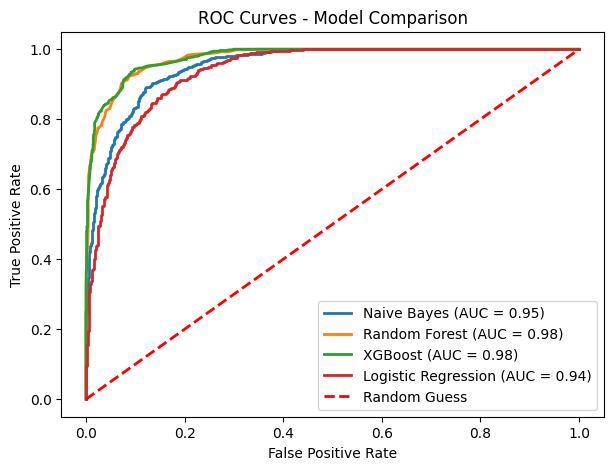

In [685]:
from sklearn.metrics import roc_curve, auc

models = {'Naive Bayes': model,'Random Forest': rf_model,'XGBoost': XGBmodel, 'Logistic Regression': lr}

plt.figure(figsize=(7, 5))

for model_name, trained_model in models.items():
    y_pred_proba = trained_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.show()

In [686]:
print(f"Logistic Regression model accuracy: {acc:.2f}%")
print(f"XGB Accuracy: {XGBaccuracy * 100:.2f}%")
print(f"RF Accuracy: {rf_accuracy * 100:.2f}%")
print(f"NB Accuracy: {accuracy * 100:.2f}%")

Logistic Regression model accuracy: 87.20%
XGB Accuracy: 93.00%
RF Accuracy: 92.13%
NB Accuracy: 81.06%


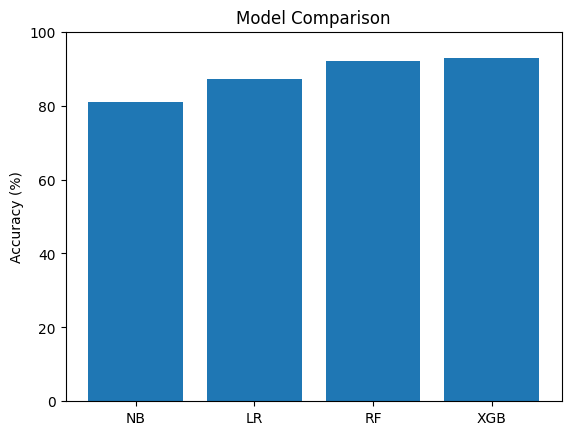

In [687]:
models = ['NB', 'LR', 'RF', 'XGB']
accuracies = [accuracy * 100, acc, rf_accuracy * 100, XGBaccuracy * 100]

plt.bar(models, accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
plt.show()